<a href="https://colab.research.google.com/github/h40huynh/fake-news-detection/blob/master/Classify_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install tensorflow==1.13.1

In [ ]:
%%capture
import os

import pandas as pd
import numpy as np

from matplotlib import style, pyplot as plt
import seaborn
style.use('seaborn')

from gensim.models import KeyedVectors

import re
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_random_seed

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from google.colab import drive
drive.mount("/content/drive")

In [ ]:
PATH_DATA = "drive/My Drive/ColabNotebooks/VietnameseFakeNews/Models/preproccess.pickle"
PATH_EMBEDDING = "drive/My Drive/ColabNotebooks/VietnameseFakeNews/Models/cc.vi.300.vec.gz"

In [ ]:
dataset = pd.read_pickle(PATH_DATA)

In [ ]:
#dataset['label'] = dataset.apply(lambda r: 1 if r['type'] == [0, 0, 0, 1] else 0, axis = 1)

In [ ]:
dataset.head()

,title,text,label
0,"[795, 774, 860, 1399, 3863, 1110, 2870, 3715, ...","[2836, 2828, 3646, 19, 47, 263, 795, 5531, 774...",1
1,"[665, 11277, 748, 461, 4896, 887, 30, 920, 714...","[277, 665, 11277, 748, 3555, 369, 23529, 22, 8...",1
2,"[2027, 292, 550, 1328, 1095, 4493, 3314, 855, ...","[335, 7, 14, 13, 24, 374, 553, 12, 578, 2822, ...",1
3,"[239, 3374, 180, 9310, 2612, 3291, 52, 847, 86...","[239, 3374, 180, 318, 454, 9310, 2612, 271, 50...",1
4,"[19, 768, 1146, 188, 1210, 109, 69, 2665, 108,...","[1821, 1344, 582, 3905, 19, 885, 774, 481, 318...",1


In [ ]:
len_content = 1799
len_title = 17

In [ ]:
# Word2Vec
model = KeyedVectors.load_word2vec_format(PATH_EMBEDDING, binary=False, limit=50000)
embed_mat = np.zeros((50000, 300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
X = dataset[['title', 'text']]
Y = dataset['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=1)

In [ ]:
del X, Y, dataset

In [ ]:
train_fit = [np.asanyarray(X_train['title'].tolist()), np.asanyarray(X_train['text'].tolist())]
valid_fit = [np.asanyarray(X_valid['title'].tolist()), np.asanyarray(X_valid['text'].tolist())]
test_fit = [np.asanyarray(X_test['title'].tolist()), np.asanyarray(X_test['text'].tolist())]

# Convolucional

In [ ]:
# Optimum params for CNN network
params_cnn = {
    'lr': 0.23993334664040306,
    'momentum': 0.30361299021107185,
    'dropout1': 0.10993063833594595,
    'dropout2': 0.1586041045258562,
    'filters1Title': 8,
    'denseTitle': 42,
    'filtersContent': 6,
    'denseContent': 34
}

In [ ]:
import tensorflow as tf
import os

from numpy.random import seed
from tensorflow.random import set_random_seed

In [ ]:
seed(50)
set_random_seed(50)
keras.backend.clear_session()

In [ ]:
# input title
title_input = keras.layers.Input(shape=(len_title,), name='title_input')
inp = keras.layers.Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], 
                             trainable=False, name='embed_title')(title_input)

x = keras.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = keras.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

# input_content
content_input = keras.layers.Input(shape=(len_content,), name='content_input')
inp2 = keras.layers.Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], 
                              trainable=False, name='embed_content')(content_input)
x2 = keras.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = keras.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = keras.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)

x2 = keras.layers.Flatten()(x2)
x2 = keras.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)

# Merge
x = keras.layers.concatenate([x, x2])

# Common part
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

out = keras.layers.Dense(1, activation='sigmoid')(x)

# Build model
model = keras.models.Model(inputs=[title_input, content_input], outputs=[out])
model.compile(keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 17)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1799)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 17, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1799, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
Conv1Title

In [ ]:
# Optimize TPU

# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

In [ ]:
model = tpu_model

In [ ]:
hist = model.fit(x=train_fit, y=np.asarray(Y_train.tolist()), batch_size=128, epochs=5, 
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], 
                 validation_data=(valid_fit, np.array(Y_valid.tolist())))

Train on 10469 samples, validate on 4488 samples
Epoch 1/5
10469/10469 [==============================] - 28s 3ms/sample - loss: 0.5778 - acc: 0.9019 - val_loss: 2.0191 - val_acc: 0.5702
Epoch 2/5
10469/10469 [==============================] - 3s 262us/sample - loss: 0.1622 - acc: 0.9827 - val_loss: 0.1190 - val_acc: 0.9893
Epoch 3/5
10469/10469 [==============================] - 3s 262us/sample - loss: 0.0713 - acc: 0.9919 - val_loss: 0.0473 - val_acc: 0.9933
Epoch 4/5
10469/10469 [==============================] - 3s 257us/sample - loss: 0.0627 - acc: 0.9907 - val_loss: 0.0452 - val_acc: 0.9969
Epoch 5/5
10469/10469 [==============================] - 3s 260us/sample - loss: 0.0777 - acc: 0.9946 - val_loss: 0.2136 - val_acc: 0.9505


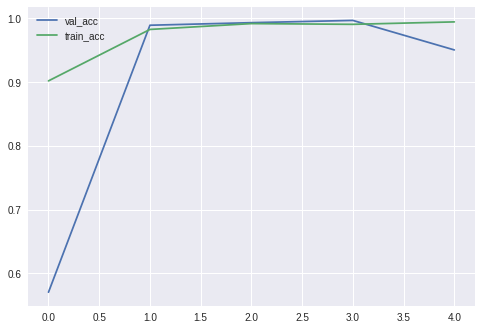

In [ ]:
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

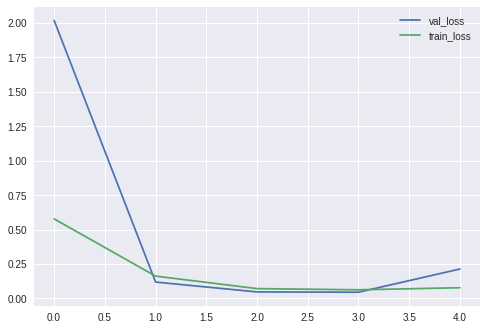

In [ ]:
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [ ]:
model = model.sync_to_cpu()
test_pred = model.predict(test_fit)
test_acc = accuracy_score(np.array(Y_test.tolist()), test_pred.round())
print("Test set acc:", test_acc)
print("Validation set acc:", hist.history['val_acc'][-1])
print('recall:', recall_score(Y_test.to_list(), test_pred.round()))
print('precision:', precision_score(Y_test.to_list(), test_pred.round()))
print('f1:', f1_score(Y_test.to_list(), test_pred.round()))

Test set acc: 0.9499298081422555
Validation set acc: 0.95053476
recall: 0.9015337423312884
precision: 1.0
f1: 0.9482174544281335


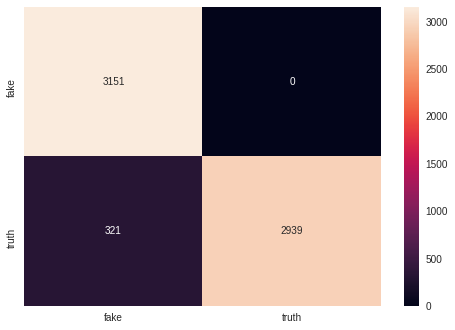

In [ ]:
matrix = confusion_matrix(np.array(Y_test.tolist()), test_pred.round())
df_cm = pd.DataFrame(matrix, columns=['fake', 'truth'], index=['fake', 'truth'])
seaborn.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
from sklearn import metrics

CNN


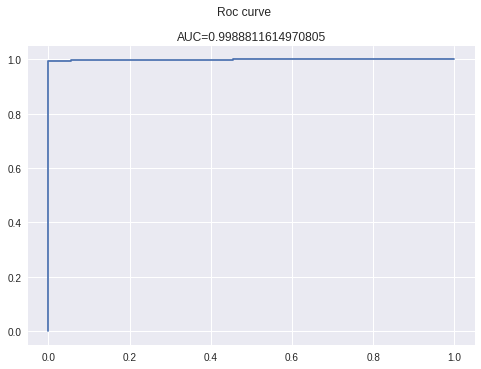

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_pred)
auc = metrics.roc_auc_score(Y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')

print("CNN")
ax.plot(fpr,tpr)

In [ ]:
#CONV_PATH = 'drive/My Drive/Colab Notebooks/fake news/weights/conv.h5'

In [ ]:
#model.save(CONV_PATH)